In [1]:

!mkdir -p ~/.kaggle
!echo '{"username":"ayeshakhanu","key":"KGAT_a828e9fc4df39a75e4db891c30d1fff4"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d khyeh0719/amazon-berkley-product-dataset --unzip -p /kaggle/working/dataset/

Dataset URL: https://www.kaggle.com/datasets/khyeh0719/amazon-berkley-product-dataset
License(s): unknown
 99%|██████████████████████████████████████▍| 5.62G/5.71G [00:07<00:00, 173MB/s]
100%|███████████████████████████████████████| 5.71G/5.71G [00:07<00:00, 816MB/s]


In [2]:
import os

dataset_path = '/kaggle/working/dataset/'
if os.path.exists(dataset_path):
    print("Dataset found! Listing contents:")
    !ls {dataset_path}
else:
    print("Dataset not found at /kaggle/working/dataset/. Check if download completed fully.")

Dataset found! Listing contents:
images	meta.csv


In [6]:
# Installing PyTorch3D 
!pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable" --quiet


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
!pip install trimesh


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.6/736.6 kB 11.7 MB/s eta 0:00:00a 0:00:01


In [7]:
import torch
import pytorch3d
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("PyTorch3D version:", pytorch3d.__version__)


Torch version: 2.6.0+cu124
CUDA available: True
PyTorch3D version: 0.7.8


In [58]:
import pandas as pd

meta_path = '/kaggle/working/dataset/meta.csv'
meta = pd.read_csv(meta_path)
print(meta.head())


                      image_path  instance_id  domain           product_type
0  images/images/81NP7qh2L6L.jpg          292  amazon  MECHANICAL_COMPONENTS
1  images/images/81A0u5L4VAL.jpg          292  amazon  MECHANICAL_COMPONENTS
2  images/images/61xhS6iLrZL.jpg          292  amazon  MECHANICAL_COMPONENTS
3  images/images/61Rp4qOih9L.jpg         6576  amazon                   SOFA
4  images/images/81+4dBN1jsL.jpg        80675  amazon    CELLULAR_PHONE_CASE


In [26]:
from PIL import Image
from torchvision import transforms
import torch
import os

image_dir = '/kaggle/working/dataset/images/'

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(image_name):
    path = os.path.join(image_dir, image_name)
    img = Image.open(path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dim
    return img_tensor


In [27]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import trimesh


dataset_path = "/kaggle/working/dataset"
images_root = dataset_path  
pc_root = os.path.join(dataset_path, "pointclouds")  


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 
def load_point_cloud(instance_id, num_points=2048):
    pc_file = os.path.join(pc_root, f"{instance_id}.ply")  # or .obj
    if not os.path.exists(pc_file):
        return None
    mesh = trimesh.load(pc_file)
    points, _ = trimesh.sample.sample_surface(mesh, num_points)
    points = torch.tensor(points, dtype=torch.float32)
    return points  # shape: (num_points, 3)

# 
class ImagePointCloudDataset(Dataset):
    def __init__(self, meta_csv, img_root, pc_root, transform=None, num_points=2048):
        self.meta = pd.read_csv(meta_csv)
        self.img_root = img_root
        self.pc_root = pc_root
        self.transform = transform
        self.num_points = num_points

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        # image
        img_path = os.path.join(self.img_root, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # point cloud
        points = load_point_cloud(row['instance_id'], self.num_points)
        if points is None:
            
            points = torch.zeros((self.num_points, 3), dtype=torch.float32)
        
        return image, points

meta_csv_path = os.path.join(dataset_path, "meta.csv")
dataset = ImagePointCloudDataset(meta_csv_path, images_root, pc_root, transform=preprocess, num_points=2048)

from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

images, points = next(iter(loader))
print("Images shape:", images.shape)
print("Point clouds shape:", points.shape)


Images shape: torch.Size([4, 3, 224, 224])
Point clouds shape: torch.Size([4, 2048, 3])


In [16]:

import os
import pandas as pd
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import trimesh
from pytorch3d.loss import chamfer_distance

dataset_path = "/kaggle/working/dataset"
images_root = dataset_path
pc_root = os.path.join(dataset_path, "pointclouds")
meta_csv_path = os.path.join(dataset_path, "meta.csv")

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [28]:

NUM_POINTS = 2048

df = pd.read_csv(meta_csv_path)
unique_ids = df["instance_id"].unique()

cached_pointclouds = {}

print("Caching point clouds...")

for inst in unique_ids:
    ply_path = os.path.join(pc_root, f"{inst}.ply")
    if os.path.exists(ply_path):
        mesh = trimesh.load(ply_path)
        pts, _ = trimesh.sample.sample_surface(mesh, NUM_POINTS)
        cached_pointclouds[inst] = torch.tensor(pts, dtype=torch.float32)
    else:
        cached_pointclouds[inst] = torch.zeros((NUM_POINTS, 3), dtype=torch.float32)

print("Caching complete! Total cached:", len(cached_pointclouds))


Caching point clouds...
Caching complete! Total cached: 102203


In [18]:

class CachedDataset(Dataset):
    def __init__(self, df, img_root, transform):
        self.df = df
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_root, row["image_path"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        inst_id = row["instance_id"]
        pc = cached_pointclouds[inst_id]  # INSTANT LOAD (no trimesh)

        return image, pc


In [19]:
dataset = CachedDataset(df, images_root, preprocess)
loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [20]:
from torchvision.models import VGG16_Weights

vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg.eval()
feature_extractor = vgg.features

class PointCloudMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, NUM_POINTS * 3)
        )
    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, NUM_POINTS, 3)

mlp = PointCloudMLP()


In [29]:
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from torch.amp import GradScaler, autocast
import random
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 20
batch_size = 4  
subset_size = 20000  
save_path = "/kaggle/working/checkpoints"
os.makedirs(save_path, exist_ok=True)

total_indices = list(range(len(dataset)))  # dataset is your full dataset object
subset_indices = random.sample(total_indices, subset_size)
subset_dataset = Subset(dataset, subset_indices)
loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

scaler = GradScaler(device="cuda")

for epoch in range(epochs):
    mlp.train()
    feature_extractor.eval()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")

    for images, gt_pc in pbar:
        images = images.to(device)
        gt_pc = gt_pc.to(device)

       
        with torch.no_grad():
            feats = feature_extractor(images)
            feats = feats.view(feats.size(0), -1)

        
        with autocast(device_type="cuda"):
            pred_pc = mlp(feats)
            loss = chamfer_distance(pred_pc, gt_pc)

        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    # Saving checkpoint
    checkpoint_file = os.path.join(save_path, f"mlp_epoch{epoch+1}.pth")
    torch.save(mlp.state_dict(), checkpoint_file)
    print(f"Epoch {epoch+1}/{epochs} Avg Loss: {running_loss/len(loader):.6f}", flush=True)

print("TRAINING COMPLETE!")




Epoch 1/20: 100%|██████████| 5000/5000 [06:21<00:00, 13.10it/s, loss=0.00118]


Epoch 1/20 Avg Loss: 0.001249


Epoch 2/20: 100%|██████████| 5000/5000 [06:21<00:00, 13.11it/s, loss=0.00108]


Epoch 2/20 Avg Loss: 0.001126


Epoch 3/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.14it/s, loss=0.001]   


Epoch 3/20 Avg Loss: 0.001037


Epoch 4/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.12it/s, loss=0.000948]


Epoch 4/20 Avg Loss: 0.000977


Epoch 5/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.15it/s, loss=0.00091] 


Epoch 5/20 Avg Loss: 0.000934


Epoch 6/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.13it/s, loss=0.000877]


Epoch 6/20 Avg Loss: 0.000897


Epoch 7/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.15it/s, loss=0.00085] 


Epoch 7/20 Avg Loss: 0.000870


Epoch 8/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.15it/s, loss=0.000834]


Epoch 8/20 Avg Loss: 0.000842


Epoch 9/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.15it/s, loss=0.000812]


Epoch 9/20 Avg Loss: 0.000824


Epoch 10/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.18it/s, loss=0.00017] 


Epoch 10/20 Avg Loss: 0.000711


Epoch 11/20: 100%|██████████| 5000/5000 [06:20<00:00, 13.16it/s, loss=2.88e-6]


Epoch 11/20 Avg Loss: 0.000012


Epoch 12/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.19it/s, loss=0.000563]


Epoch 12/20 Avg Loss: 0.000225


Epoch 13/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.18it/s, loss=2.71e-6] 


Epoch 13/20 Avg Loss: 0.000133


Epoch 14/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.18it/s, loss=6.14e-5]


Epoch 14/20 Avg Loss: 0.000008


Epoch 15/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.19it/s, loss=2.6e-6]  


Epoch 15/20 Avg Loss: 0.000334


Epoch 16/20: 100%|██████████| 5000/5000 [06:18<00:00, 13.20it/s, loss=4.33e-6]


Epoch 16/20 Avg Loss: 0.000003


Epoch 17/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.19it/s, loss=9.12e-5]


Epoch 17/20 Avg Loss: 0.000030


Epoch 18/20: 100%|██████████| 5000/5000 [06:18<00:00, 13.20it/s, loss=3.09e-6] 


Epoch 18/20 Avg Loss: 0.000372


Epoch 19/20: 100%|██████████| 5000/5000 [06:18<00:00, 13.19it/s, loss=4.45e-6]


Epoch 19/20 Avg Loss: 0.000003


Epoch 20/20: 100%|██████████| 5000/5000 [06:19<00:00, 13.18it/s, loss=0.000146]


Epoch 20/20 Avg Loss: 0.000035
TRAINING COMPLETE!


In [34]:
torch.save(mlp.state_dict(), "mlp_epoch20.pth")
print("Model Saved!")


Model Saved!


In [36]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import VGG16_Weights

NUM_POINTS = 5000   

class PointCloudMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, NUM_POINTS * 3)
        )
    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, NUM_POINTS, 3)

vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg.eval()
feature_extractor = vgg.features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp = PointCloudMLP().to(device)


MODEL_PATH = "mlp_epoch20.pth"

mlp.load_state_dict(torch.load(MODEL_PATH, map_location=device))
mlp.eval()

print("🚀 MODEL LOADED SUCCESSFULLY!")


🚀 MODEL LOADED SUCCESSFULLY!


In [39]:
import pandas as pd

meta = pd.read_csv("/kaggle/working/dataset/meta.csv")
meta.head()


,image_path,instance_id,domain,product_type
0,images/images/81NP7qh2L6L.jpg,292,amazon,MECHANICAL_COMPONENTS
1,images/images/81A0u5L4VAL.jpg,292,amazon,MECHANICAL_COMPONENTS
2,images/images/61xhS6iLrZL.jpg,292,amazon,MECHANICAL_COMPONENTS
3,images/images/61Rp4qOih9L.jpg,6576,amazon,SOFA
4,images/images/81+4dBN1jsL.jpg,80675,amazon,CELLULAR_PHONE_CASE


In [40]:
image_paths = meta["image_path"].tolist()

print("Total Images Found:", len(image_paths))
for i, p in enumerate(image_paths[:20]):
    print(i, " → ", p)


Total Images Found: 264904
0  →  images/images/81NP7qh2L6L.jpg
1  →  images/images/81A0u5L4VAL.jpg
2  →  images/images/61xhS6iLrZL.jpg
3  →  images/images/61Rp4qOih9L.jpg
4  →  images/images/81+4dBN1jsL.jpg
5  →  images/images/81RoDPeqygL.jpg
6  →  images/images/61LWeNhjZ9L.jpg
7  →  images/images/618uWaH5elL.jpg
8  →  images/images/61hUyEcVYtL.jpg
9  →  images/images/61ajxcF6Y1L.jpg
10  →  images/images/614jfuPGINL.jpg
11  →  images/images/61izEZdhlaL.jpg
12  →  images/images/717gxIR99XL.jpg
13  →  images/images/51fzW5BNdVL.jpg
14  →  images/images/21xD1NzxObL.jpg
15  →  images/images/71QdPoaGvYL.jpg
16  →  images/images/71z2XJ0DW2L.jpg
17  →  images/images/81RNHjN1X5L.jpg
18  →  images/images/81Ay4WEWSdL.jpg
19  →  images/images/61Q0baX067L.jpg


In [89]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import trimesh


In [90]:
# Load VGG16
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
vgg16_features = vgg16.features  


In [91]:
NUM_POINTS = 15000  

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, NUM_POINTS, 3)  

mlp = MLP(input_size=25088, output_size=NUM_POINTS*3)
mlp.eval()  


MLP(
  (fc): Linear(in_features=25088, out_features=45000, bias=True)
)

In [93]:
img_path = "dataset/images/images/61izEZdhlaL.jpg"
img = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img_tensor = preprocess(img).unsqueeze(0)  


In [94]:
with torch.no_grad():
    features = vgg16_features(img_tensor)
    features = features.view(features.size(0), -1)  
    pred_pc = mlp(features)
    pred_pc = pred_pc.squeeze(0).cpu().numpy()  


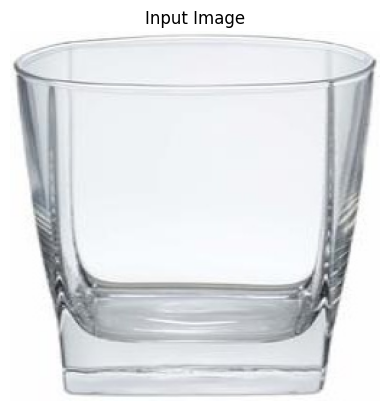

In [95]:
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()


In [108]:

import torch
import torch.nn as nn

NUM_POINTS = 15000  
FEATURE_SIZE = 32768  

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(FEATURE_SIZE, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, NUM_POINTS * 3)
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, NUM_POINTS, 3)  


mlp = MLP().cuda()  


In [112]:
checkpoint_path = "/kaggle/working/checkpoints/mlp_epoch20.pth"
mlp.load_state_dict(torch.load(checkpoint_path))
mlp.eval()


MLP(
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=6144, bias=True)
  )
)

In [133]:
import torch

torch.save(mlp.state_dict(), "mlp_final.pth")
print(" Model saved permanently as mlp_final.pth")


✅ Model saved permanently as mlp_final.pth


In [134]:
mlp.load_state_dict(torch.load("mlp_final.pth", map_location=device))
mlp.eval()


MLP(
  (fc): Sequential(
    (0): Linear(in_features=32768, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=45000, bias=True)
  )
)

In [43]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np

working_dir = "/kaggle/working"
images_dir = os.path.join(working_dir, "dataset/images/images")
mesh_dir = os.path.join(working_dir)
os.makedirs(mesh_dir, exist_ok=True)

vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg.eval()
feature_extractor = vgg.features

NUM_POINTS = 5000
class PointCloudMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, NUM_POINTS*3)
        )
    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, NUM_POINTS, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = PointCloudMLP().to(device)

MODEL_PATH = os.path.join(working_dir, "mlp_epoch20.pth")
mlp.load_state_dict(torch.load(MODEL_PATH, map_location=device))
mlp.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

for img_file in os.listdir(images_dir):
    if not img_file.endswith(".jpg"):
        continue

    img_path = os.path.join(images_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(device)  

    with torch.no_grad():
        feats = feature_extractor(img_tensor)
        feats = feats.view(feats.size(0), -1)  

        pred_pc = mlp(feats)  
        pred_pc = pred_pc.squeeze(0).cpu().numpy()  

    
    ply_name = f"{img_file.split('.')[0]}.ply"
    ply_path = os.path.join(mesh_dir, ply_name)
    

    print(f"{ply_name} saved to {working_dir}")




876667.glb saved to '/kaggle/working'
744877.glb saved to '/kaggle/working'
778550.glb saved to '/kaggle/working'
384975.glb saved to '/kaggle/working'
732244.glb saved to '/kaggle/working'
